# A/B Testing (Non-Parametric Tests)

###    Assumptions: Non-parametric tests do not make strict assumptions about the population parameters or the distribution of the data. They are often referred to as distribution-free tests. They are suitable for ordinal data, data with ranks, or data that are not normally distributed.

![image.png](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*oJWBEpXPpIcZZX-K.jpg)


from https://towardsdatascience.com/hypothesis-tests-explained-8a070636bd28

In [66]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [67]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# import plotly
import plotly.express as px
import plotly.graph_objects as go
# plotly.offline.init_notebook_mode (True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from math import *

%matplotlib inline

In [68]:
from scipy.stats import ttest_1samp, mannwhitneyu, shapiro, norm, t, kstest, shapiro, levene, pearsonr
from statsmodels.stats.power import TTestIndPower # estimate sample size via power analysis
from statsmodels.stats import proportion
import statsmodels.stats.power as smp

In [69]:
import platform
print(f"OS version: {platform.platform()}")
print(f"Python version: {platform.python_version()}")
print(f"numpy version: {np.__version__}")
print(f"panda version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")

OS version: Windows-11-10.0.22621-SP0
Python version: 3.12.3
numpy version: 1.26.4
panda version: 2.1.4
seaborn version: 0.13.2
matplotlib version: 3.7.5


In [70]:
# #### data from https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing?resource=download
# load data into a dataframe
url = '/users/simon/cookie_cats.csv';
ab_df= pd.read_csv(url,  index_col= None, na_values='?')
ab_df.head()

userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

### Dataset and Variables
    The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:
    
    userid - a unique number that identifies each player.
    version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
    sum_gamerounds - the number of game rounds played by the player during the first 14 days after install.
    retention_1 - did the player come back and play 1 day after installing?
    retention_7 - did the player come back and play 7 days after installing?

In [71]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [72]:
# Total missing values, NA, for each feature
print (ab_df.isnull().sum() )

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [73]:
# Check if there are duplicated ID
ab_df['userid'].nunique() == ab_df['userid'].count()

True

In [74]:
ab_df.describe().T

count          mean           std    min        25%  \
userid          90189.0  4.998412e+06  2.883286e+06  116.0  2512230.0   
sum_gamerounds  90189.0  5.187246e+01  1.950509e+02    0.0        5.0   

                      50%        75%        max  
userid          4995815.0  7496452.0  9999861.0  
sum_gamerounds       16.0       51.0    49854.0

In [75]:
# Find the average number of game rounds for each version, and the standard deviation and the number of values

version_group = (ab_df.groupby("version").agg(["mean", "std", "count"])["sum_gamerounds"]).round(3)
version_group

mean      std  count
version                        
gate_30  52.456  256.716  44700
gate_40  51.299  103.294  45489

In [76]:
df_retention_ab = ab_df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

userid  retention_1  retention_7  sum_gamerounds
version                                                  
gate_30   44700     0.448188     0.190201         2344795
gate_40   45489     0.442283     0.182000         2333530

In [77]:
fig = px.box(ab_df, x="version", y="sum_gamerounds",  log_y=True)

# Lets update the figure using update_layout() method on fig
fig.update_layout(
    title="number of rounds distribution in 2 groups",
    xaxis_title="version",
    yaxis_title="log(sum_gamerounds)",
    width=600,
    height=600
)
# Display the plot
fig.show()

In [78]:
print("Players inactive since installation: ", ab_df[ab_df["sum_gamerounds"] == 0].shape[0])

Players inactive since installation:  3994


In [79]:
# sum_gamerounds = 0  => players never played the game, just installed it
# drop those sum_gamerounds = 0 or 49854
df_filtered = ab_df[~ab_df['sum_gamerounds'].isin([0, 49854])]

In [80]:
fig = px.box(df_filtered, x="version", y="sum_gamerounds", log_y=True)

# Lets update the figure using update_layout() method on fig
fig.update_layout(
    title="number of rounds distribution in 2 groups",
    xaxis_title="version",
    yaxis_title="log(sum_gamerounds)",
    width=600,
    height=600
)
# Display the plot
fig.show()

In [81]:
fig = px.histogram(df_filtered, x='sum_gamerounds', color="version", barmode="stack",
                  title="Distribution of game rounds")
fig.show(renderer='colab')

In [82]:
# check the samples for the normal distribution.
# let's use Kolmogorov-Smirnov test
# With P-Value> Alpha: the analyzed distribution does not differ from normal.
print(kstest(df_filtered['sum_gamerounds'], 'norm'))

KstestResult(statistic=0.9129994561902063, pvalue=0.0, statistic_location=2, statistic_sign=-1)


#### P-value is too low, distribution isn't normal.

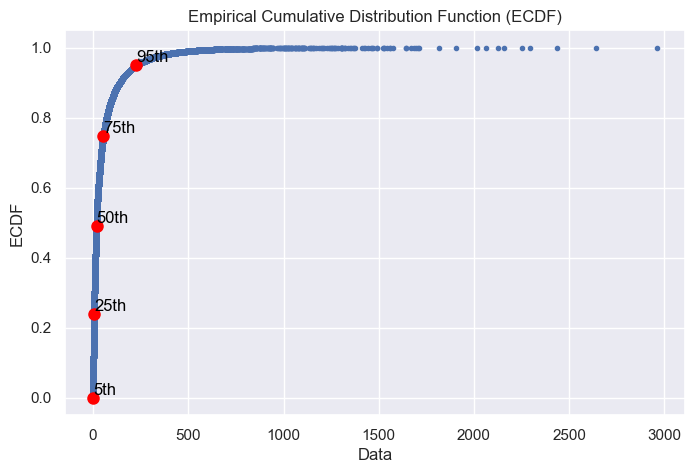

In [83]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

def plot_ecdf_with_percentiles(data, percentiles=[5,25, 50, 75, 95]):
    """Plot ECDF and add percentile markers as dots."""
    x, y = ecdf(data)
    
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker='.', linestyle='none')
    plt.xlabel('Data')
    plt.ylabel('ECDF')
    
    # Add percentile markers as dots
    for percentile in percentiles:
        value = np.percentile(data, percentile)
        ecdf_value = np.searchsorted(x, value) / len(x)
        plt.plot(value, ecdf_value, marker='o', color='red', markersize=8)
        plt.text(value, ecdf_value, f'{percentile}th', color='black', verticalalignment='bottom')
    
    plt.title('Empirical Cumulative Distribution Function (ECDF)')
    plt.show()

plot_ecdf_with_percentiles(df_filtered['sum_gamerounds'])

#### As we see 95% of our data is below 500 Game Rounds.

### Use Levene’s Test to assess the equality of variances between two groups gamerounds

    Null Hypothesis (H0): The variances of the two groups are equal.
    Alternative Hypothesis (Ha): The variances of the two groups are not equal.

In [84]:
# Extract the retention_1 data for the two groups
group_30 = df_filtered[df_filtered['version'] == 'gate_30']['sum_gamerounds']
group_40 = df_filtered[df_filtered['version'] == 'gate_40']['sum_gamerounds']

# Perform Levene's Test
stat, p_value = levene(group_30, group_40)

print(f'Levene\'s Test Statistic: {stat}, p-value: {p_value}')

Levene's Test Statistic: 0.15966584601272976, p-value: 0.6894653407287958


#### the p-value is greater than the significance level (0.05), you accept the null hypothesis and conclude that the variances are not significantly different.

### Checking Sample Ratio Mismatch

In [85]:
# from https://hex.tech/blog/AB-testing/

from scipy.stats import chi2_contingency, chisquare

def SRM(dataframe):
    gate_30 = dataframe["version"].value_counts().loc["gate_30"]
    gate_40 = dataframe["version"].value_counts().loc["gate_40"]

    print("Number of players in group A (gate_30):",gate_30)
    print("Number of players in group B (gate_40):",gate_40)
    
    observed = [ gate_30, gate_40 ]
    total_player= sum(observed)
    expected = [ total_player/2, total_player/2 ]

    # use chisquare when you want to test whether one (discrete) random variable has a specific distribution
    chi = chisquare(observed, f_exp=expected)
    print(f"p-value: {round(chi[1], 4)}\n")
    if chi[1] < 0.05:
        print('SRM detected')
    else:
        print('No SRM detected')

SRM(df_filtered)

Number of players in group A (gate_30): 42762
Number of players in group B (gate_40): 43432
p-value: 0.0225

SRM detected


#### there's a significant difference in the distribution of our two groups.  

### Bootstrapping

#### Bootstrapping is any test or metric that uses random sampling with replacement (e.g. mimicking the sampling process), and falls under the broader class of resampling methods.

In [86]:
# from https://hex.tech/blog/AB-testing/
# sampling our dataset 1000 times and calculate the average retention rate for each sample.
def bootstrap_distribution(df, group, limit = 1000):

    # function borrowed from https://www.kaggle.com/code/serhanturkan/a-b-testing-for-mobile-game-cookie-cats
    bootstrap_retention = pd.DataFrame(
        [
            df.sample(frac=1, replace=True).groupby("version")[group].mean()
            for i in range(limit)
        ]
    )

    sns.set(rc={"figure.figsize": (18, 5)})
    bootstrap_retention.plot.kde()
    plt.title(
        "KDE Plot of the 1 day retention's bootstrap distributions"
        if group == "retention_1"
        else "KDE Plot of the 7 day retention's bootstrap distributions",
        fontweight="bold",
    )
    plt.xlabel("Retention rate")
    plt.show()

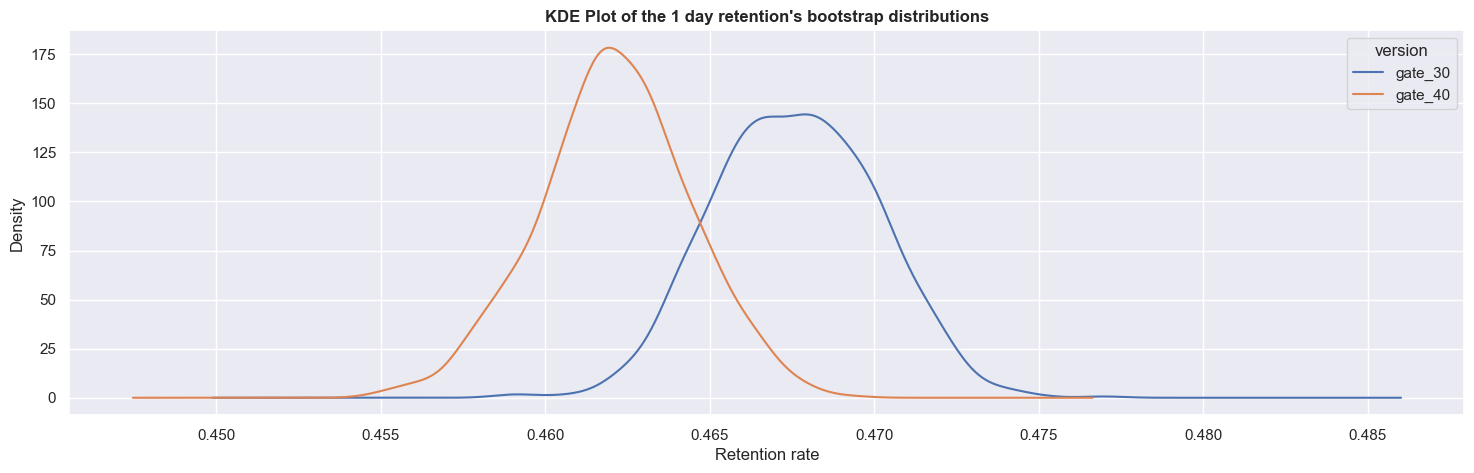

In [87]:
bootstrap_distribution(df_filtered, "retention_1")

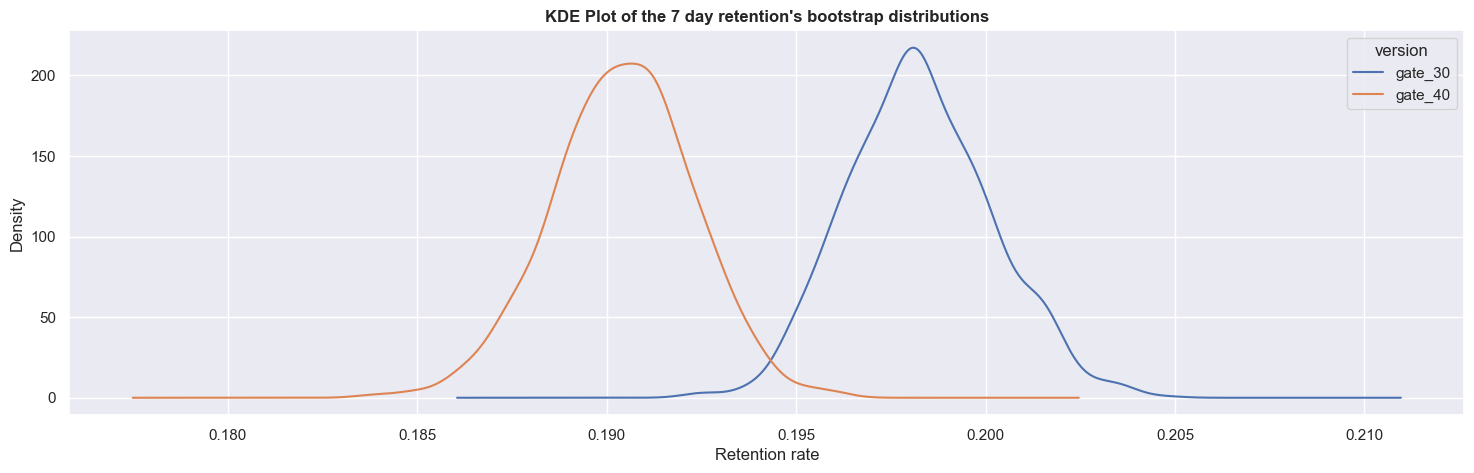

In [88]:
bootstrap_distribution(df_filtered, "retention_7")

#### Notice that the gap between the groups in the 7-day retention chart is much larger than in the 1-day retention chart. Here, we also see that the treatment group retention is slightly lower than the control group on 1-day retention. 

### Conducting the test

####  Chi-square test to verify if the difference between groups is statistically significant or not, which will determine the results of our hypotheses.

    1. Any difference in version

    H0 (Null hypothesis) : Changing the gate level has no impact on sum_gamerounds
    Ha (Alternative hypothesis): Changing the gate level has an impact on sum_gamerounds

In [89]:
# Function for Mann-Whitney U Test

def mannwhitneyfunc(value1,value2):

    stat, p=mannwhitneyu(sum_gamerounds1, sum_gamerounds2)

    alpha=0.05 

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two groups have no significant difference')
    else:
        print('Two groups have a significant difference')

In [90]:
#Mann-Whitney U Test for sum_gamerounds

sum_gamerounds1 = df_filtered[df_filtered.version=='gate_30'].sum_gamerounds
sum_gamerounds2 = df_filtered[df_filtered.version=='gate_40'].sum_gamerounds

mannwhitneyfunc(sum_gamerounds1,sum_gamerounds2)

p=0.1177 , alpha=0.05 
Two groups have no significant difference


#### No statistically significant difference between groups. They have similar sum_gamerounds.

    2. Any difference between retention_1 and retention_7

In [91]:
# Create a contingency table
contingency_table = pd.crosstab(df_filtered['retention_1'], df_filtered['retention_7'])
print(contingency_table)

# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)
if abs(p) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

retention_7  False  True 
retention_1              
False        42554   3574
True         26889  13177
Chi-squared Statistic: 8653.789327838105
P-value: 0.0
Degrees of Freedom: 1
Expected Frequencies:
[[37163.45341903  8964.54658097]
 [32279.54658097  7786.45341903]]
We may reject the null hypothesis!


#### We can accept that there is significant difference between retention_1 and retention_7

    3. Any difference between in the retention of our control and treatment groups after 1 day.

In [92]:
# Create a contingency table
contingency_table = pd.crosstab(df_filtered['version'], df_filtered['retention_1'])
print(contingency_table)
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)
if abs(p) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

retention_1  False  True 
version                  
gate_30      22769  19993
gate_40      23359  20073
Chi-squared Statistic: 2.47671866669166
P-value: 0.11554308221600512
Degrees of Freedom: 1
Expected Frequencies:
[[22884.71977168 19877.28022832]
 [23243.28022832 20188.71977168]]
We have failed to reject the null hypothesis


#### We can accept that there is no significant difference of retention_1 between 2 groups
#### We conclude that being in the group that sees the first gate at level 40 has no effect on retention after 1 day

    4. Any difference between in the retention of our control and treatment groups after 7 day.

In [93]:
# Create a contingency table
contingency_table = pd.crosstab(df_filtered['version'], df_filtered['retention_7'])
print(contingency_table)
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)
if abs(p) < 0.05:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

retention_7  False  True 
version                  
gate_30      34277   8485
gate_40      35166   8266
Chi-squared Statistic: 8.984877907964687
P-value: 0.0027222297777463066
Degrees of Freedom: 1
Expected Frequencies:
[[34451.60412558  8310.39587442]
 [34991.39587442  8440.60412558]]
We may reject the null hypothesis!


#### We can accept that there is significant difference of retention_7 between 2 groups.
#### We conclude that being in the group that sees the first gate at level 40 has no effect on retention after 1 day

## Statistical power of A/B test - Calculate Difference Effect Size

In [94]:
# from https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python

def cohend(d1: pd.Series, d2: pd.Series) -> float:

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))

    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)

    # return the effect size
    return print(f"Cohen's d: {(u1 - u2) / s }")

In [95]:
# Calculate retention rates for retention_1
group_A = df_filtered[df_filtered['version'] == 'gate_30']['retention_1']
group_B = df_filtered[df_filtered['version'] == 'gate_40']['retention_1']

cohend(group_A , group_B)

Cohen's d: 0.010767744714703544


In [96]:
# Calculate retention rates fro retention_7
group_A = df_filtered[df_filtered['version'] == 'gate_30']['retention_7']
group_B = df_filtered[df_filtered['version'] == 'gate_40']['retention_7']

cohend(group_A , group_B)

Cohen's d: 0.020479712511401776


####    find Cohen’s d of both retentions 0.01 and 0.02. This means that the average score of students in the experimental group is 0.02 standard deviations higher than the average score of students in the control group. This would still be considered a small effect size, but it indicates that the experimental group performed better.

    •	Positive Cohen’s d: The experimental group has a higher mean.
    •	Negative Cohen’s d: The control group has a higher mean.
    
    Small Effect Size: d=0.20
    Medium Effect Size: d=0.50
    Large Effect Size: d=0.80

In [97]:
# Perform power analysis
power_analysis = TTestIndPower()
sample_size = df_retention_ab['userid'].min()
alpha = 0.05  # Significance level

power = power_analysis.solve_power(effect_size=cohen_d, nobs1=sample_size, alpha=alpha, ratio=1.0, alternative='two-sided')
print(f"Statistical Power: {power}")

Statistical Power: 0.3632665387431571


#### Interpreting Power Value
    High Power (e.g., 0.80 or 80%): This means there is an 80% chance of detecting an effect if it exists. High power reduces the risk of Type II errors, making your test more reliable.
    Low Power (e.g., 0.50 or 50%): This means there is only a 50% chance of detecting an effect if it exists. Low power increases the risk of Type II errors, making your test less reliable.

#### Power is LOW. We do not have large enought sample size to trust statistical results obtained above.

### Calculate Association Effect Size

In [98]:
# Calculate retention rates for retention_7
group_A = df_filtered[df_filtered['version'] == 'gate_30']['retention_7']
group_B = df_filtered[df_filtered['version'] == 'gate_40']['retention_7']

# Truncate the longer variable to match the length of the shorter one
min_length = min(len(group_A), len(group_B))
variable1 = group_A[:min_length]
variable2 = group_B[:min_length]


# calculate Pearson's correlation
corr, p = pearsonr(variable1 , variable2)
print('Pearsons correlation: %.3f' % corr)
print(f"P-value: {p_value}")

Pearsons correlation: -0.001
P-value: 0.6894653407287958


#### We have Weak negative relationship on retention_7

The Pearson’s correlation coefficient measures the degree of linear association between two real-valued variables. It is a unit-free effect size measure, that can be interpreted in a standard way, as follows:
    
    -1.0: Perfect negative relationship.
    -0.7: Strong negative relationship
    -0.5: Moderate negative relationship
    -0.3: Weak negative relationship
    0.0: No relationship.
    0.3: Weak positive relationship
    0.5: Moderate positive relationship
    0.7: Strong positive relationship
    1.0: Perfect positive relationship.

##### from https://machinelearningmastery.com/effect-size-measures-in-python/

### Reference
    
    
    https://github.com/Zach-Nabavian/A-B-Testing-Mobile-App/blob/main/AB%20Testing.ipynb
    https://www.kaggle.com/code/nadezhdagruzdeva/mobile-games-a-b-testing-cookie-cats
    https://github.com/robguilarr/ab_testing_cookie_cats/blob/main/notebook.ipynb
    https://github.com/adityajanardhan/MOBILE-GAMES-A-B-TESTING-WITH-COOKIE-CATS/blob/master/notebook.ipynb
    https://github.com/K-Ashik/Mobile-Game-A-B-Testing/blob/main/notebook.ipynb
    https://github.com/akthammomani/AB-Testing-cookie-CATS/blob/main/Notebook/AB_Testing_cookie_CATS_complete.ipynb
    https://www.kaggle.com/code/mursideyarkin/mobile-games-ab-testing-with-cookie-cats
    https://github.com/robguilarr/ab_testing_cookie_cats/blob/main/notebook.ipynb
    https://towardsdatascience.com/hypothesis-tests-explained-8a070636bd28
    https://medium.com/@haticeyildiz/what-is-the-parametric-and-non-parametric-tests-e0287eecaac0
    https://towardsdatascience.com/non-parametric-tests-in-hypothesis-testing-138d585c3548
    https://blog.mirkopeters.com/understanding-parametric-and-non-parametric-tests-b9b278aa5d49
    https://pub.towardsai.net/what-is-parametric-and-non-parametric-in-statistic-learn-with-python-example-ecb2da172516
    https://towardsdatascience.com/the-ultimate-guide-to-a-b-testing-part-4-non-parametric-tests-4db7b4b6a974
    https://medium.com/@abhishekjainindore24/understanding-parametric-and-nonparametric-tests-a-comprehensive-guide-0d922dc571c2